# Site Suitability Analysis for Hospital Locations

## Step 1: Prepare the Data
- Export raster datasets and weights from ArcGIS Pro.
- Use libraries like rasterio, numpy, and pandas to process raster data.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import rasterio

In [4]:
fpath = r"spatial_data\reclass_popd1"
os.path.split(fpath)

('spatial_data', 'reclass_popd1')

In [5]:
# Folder paths for the rasters
folder_paths = [
    r"spatial_data\reclass_popd1",  # Population density
    r"spatial_data\reclass_hosp1",  # Hospital proximity
    r"spatial_data\reclass_road1",  # Road proximity
    r"spatial_data\reclass_land1",  # Land use
    r"spatial_data\reclass_slop1"   # Slope
]

In [6]:
for folder_path in folder_paths:
    # Remove leading/trailing spaces if any
    folder_path = folder_path.strip()
    try:
        with rasterio.open(folder_path) as src:
            # Print raster metadata
            print("Raster Metadata:")
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            print(f"Shape: {src.shape}")
            print(f"Number of Bands: {src.count}")
    except Exception as e:
        print(f"Error loading raster: {e}")

Raster Metadata:
CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Bounds: BoundingBox(left=-82.012000962637, bottom=41.22293603077, right=-81.335089098989, top=41.681367013054)
Shape: (1452, 2144)
Number of Bands: 1
Raster Metadata:
CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Bounds: BoundingBox(left=-82.012000962637, bottom=41.22293603077, right=-81.335089098989, top=41.681367013054)
Shape: (1452, 2144)
Number of Bands: 1
Raster Metadata:
CRS: GEOGCS["WGS 84",DATUM["WGS_1

In [7]:
# List of raster layer names corresponding to folder paths
layer_names = ["pop_density", "hosp_prox", "road_prox", "land_use", "slope"]

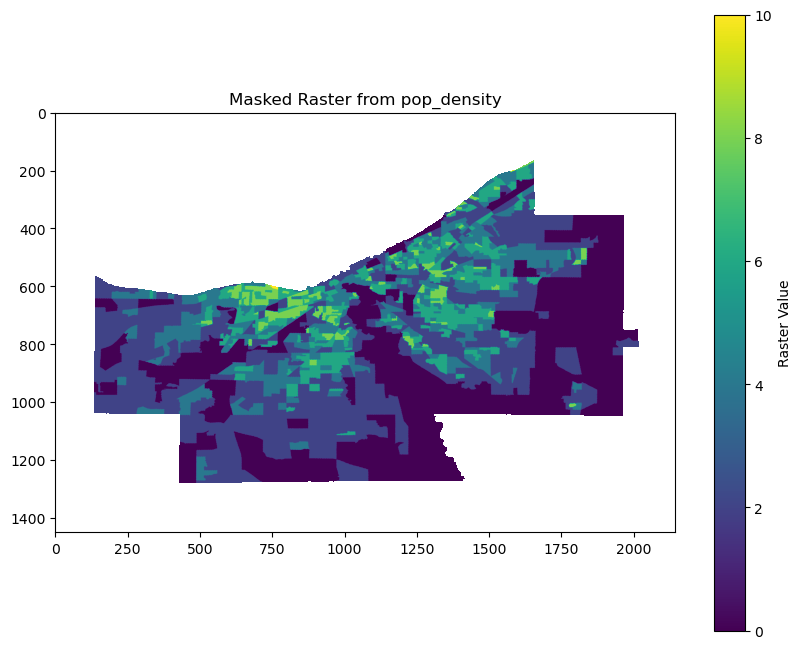

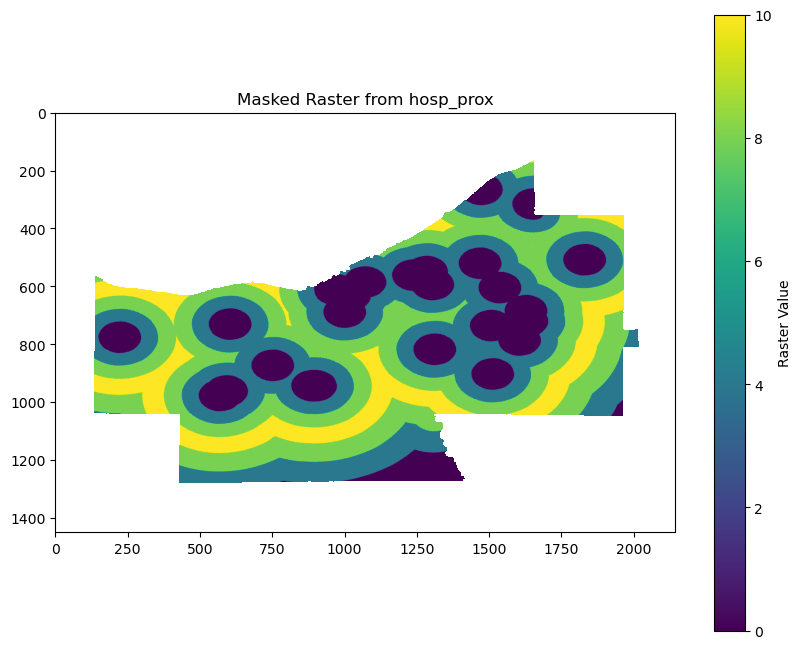

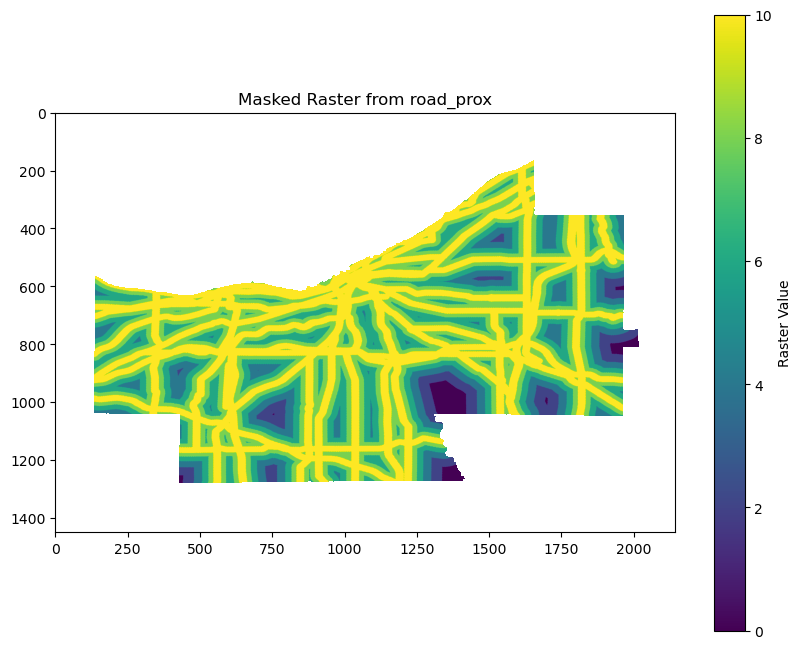

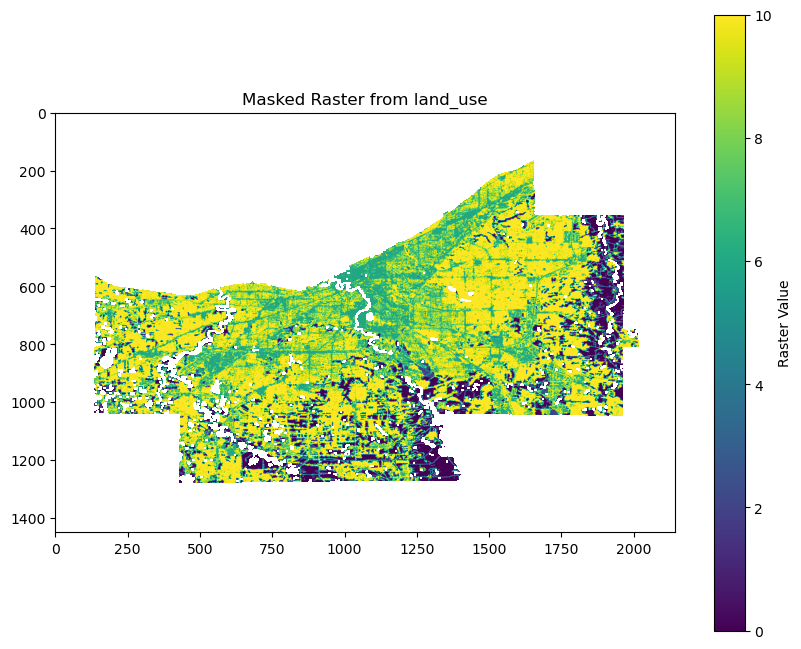

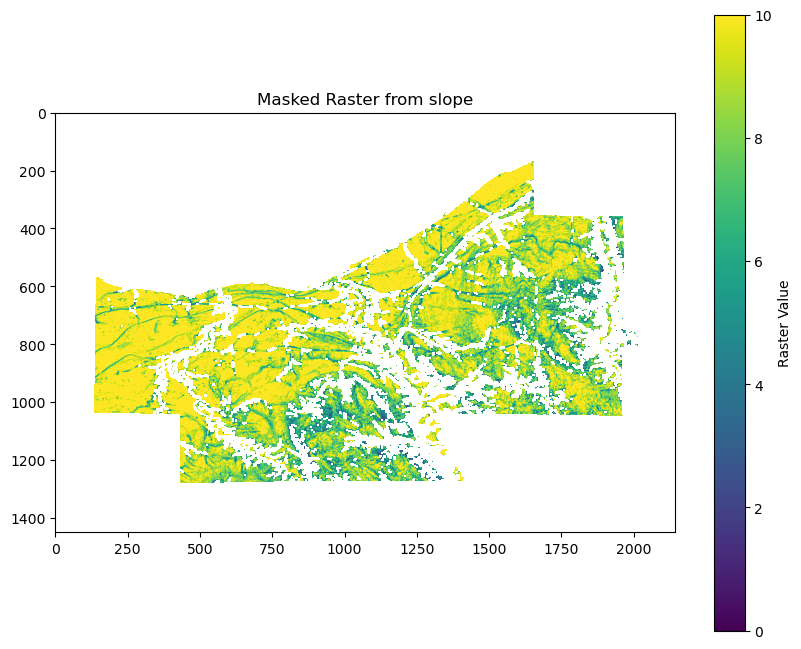

In [8]:
for layer_name, folder_path in zip(layer_names, folder_paths):
    folder_path = folder_path.strip()
    try:
        with rasterio.open(folder_path) as src:
            data = src.read(1)  # Read the first band
            nodata_value = src.nodata  # Get NoData value
            masked_raster = np.ma.masked_equal(data, nodata_value)
            
            # Plot each masked raster
            plt.figure(figsize=(10, 8))
            plt.title(f"Masked Raster from {layer_name}")
            plt.imshow(masked_raster, cmap="viridis")
            plt.colorbar(label="Raster Value")
            plt.show()
    except Exception as e:
        print(f"Error plotting raster: {e}")

In [9]:
# Dictionary to store masked raster datasets
masked_rasters = {}

# Load and process rasters
for layer_name, folder_path in zip(layer_names, folder_paths):
    try:
        # Open raster file
        with rasterio.open(folder_path) as src:
            # Read data and mask NoData values
            data = src.read(1)
            nodata_value = src.nodata
            masked_rasters[layer_name] = np.ma.masked_equal(data, nodata_value)
    except Exception as e:
        print(f"Error loading raster {layer_name} from {folder_path}: {e}")


## Step 2: Define Weighted Overlay Function
- Create a function to compute suitability scores for different weights.

In [10]:
# Define weighted overlay function
def weighted_overlay(masked_rasters, weights):
    """
    Calculate suitability map based on weighted overlay.
    Parameters:
        masked_rasters: dict of np.ma.MaskedArray
        weights: list of float
    Returns:
        np.ma.MaskedArray - Weighted suitability map
    """
    # Ensure weights sum to 1
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Perform weighted overlay
    suitability = sum(
        weights[i] * masked_rasters[layer]
        for i, layer in enumerate(layer_names)
    )
    return suitability

## Step 3: Vary Weights
- Define weight scenarios and calculate suitability scores for each scenario.

In [11]:
# Define weight scenarios
scenarios = [
    [0.4, 0.2, 0.2, 0.1, 0.1],  # Scenario 1
    [0.31, 0.23, 0.20, 0.14, 0.12],  # Scenario 2
    [0.3, 0.3, 0.2, 0.1, 0.1],  # Scenario 3   
    [0.27, 0.22, 0.19, 0.17, 0.15] # Scenario 4
]

## Step 4. Compute Suitability Maps for Each Scenario
- Use the defined scenarios to calculate suitability maps for each.

In [12]:
# Create suitability maps
suitability_maps = []
for scenario_id, weights in enumerate(scenarios):
    suitability_map = weighted_overlay(masked_rasters, weights)
    suitability_maps.append(suitability_map)
    print(f"Suitability map for Scenario {scenario_id + 1} created.")

Suitability map for Scenario 1 created.
Suitability map for Scenario 2 created.
Suitability map for Scenario 3 created.
Suitability map for Scenario 4 created.


## Step 5. Compare Suitability Maps
- Evaluate the performance of each scenario using the following steps:

### a. Statistical Comparison
- Calculate metrics like mean suitability score, variance, or percentage of high-suitability areas for each scenario:

In [13]:
# Calculate statistics for each suitability map
stats = []
for i, suitability_map in enumerate(suitability_maps):
    mean_score = np.mean(suitability_map)
    std_dev = np.std(suitability_map)
    high_suitability_area = np.sum(suitability_map >= 7)  # Example threshold
    stats.append((i + 1, mean_score, std_dev, high_suitability_area))

In [14]:
# Display the results
df = pd.DataFrame(stats, columns=["Scenario", "Mean Score", "Std Dev", "High Suitability Area"])
print(df)

   Scenario  Mean Score   Std Dev  High Suitability Area
0         1    5.025952  1.329020                  75727
1         2    5.438751  1.334295                 129843
2         3    5.323935  1.352529                 133499
3         4    5.682178  1.359849                 200484


### b. Visual Inspection
- Plot and visually inspect the suitability maps for each scenario to identify patterns and anomalies.

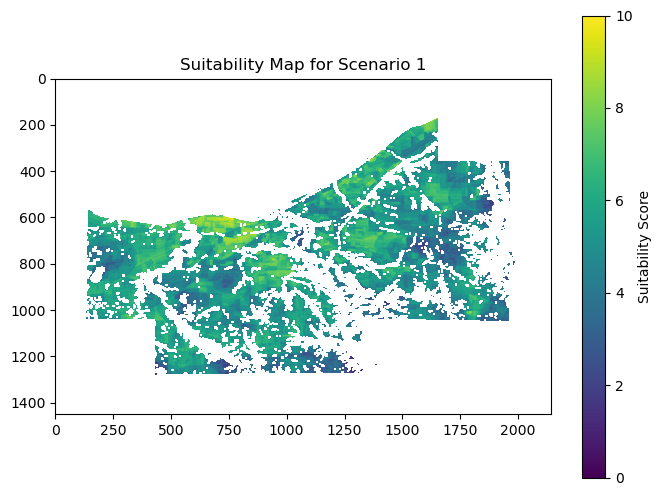

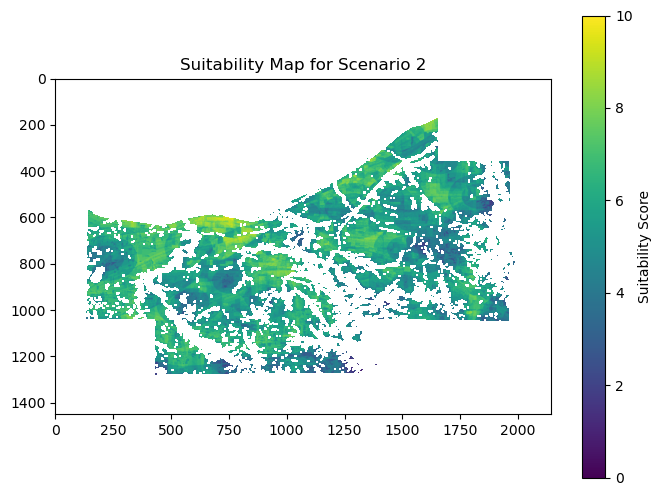

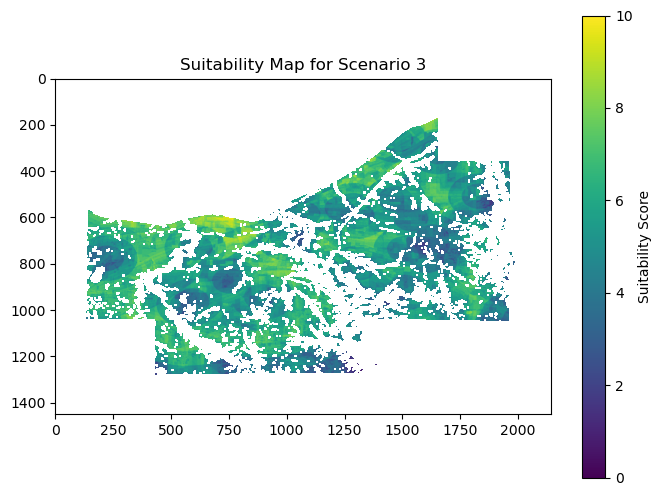

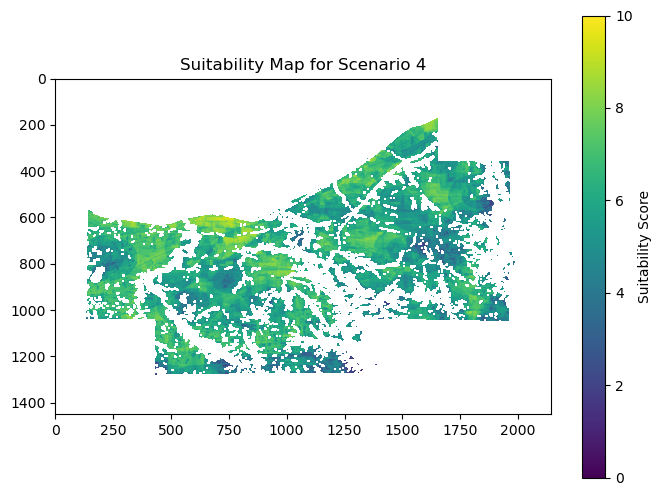

In [15]:
# Visualize each suitability map
for i, suitability_map in enumerate(suitability_maps):
    plt.figure(figsize=(8, 6))
    plt.title(f"Suitability Map for Scenario {i + 1}")
    plt.imshow(suitability_map, cmap="viridis")
    plt.colorbar(label="Suitability Score")
    plt.show()

## Step 6: Analyze Results
- Calculate the range and standard deviation across all scenarios.

In [16]:
# Stack suitability maps
suitability_stack = np.stack(suitability_maps)

In [17]:
# Compute range and standard deviation
range_map = np.ptp(suitability_stack, axis=0)  # Range (max - min)
std_dev_map = np.std(suitability_stack, axis=0)  # Standard deviation

## Step 7: Visualize Results
- Use libraries like matplotlib to visualize sensitivity metrics.

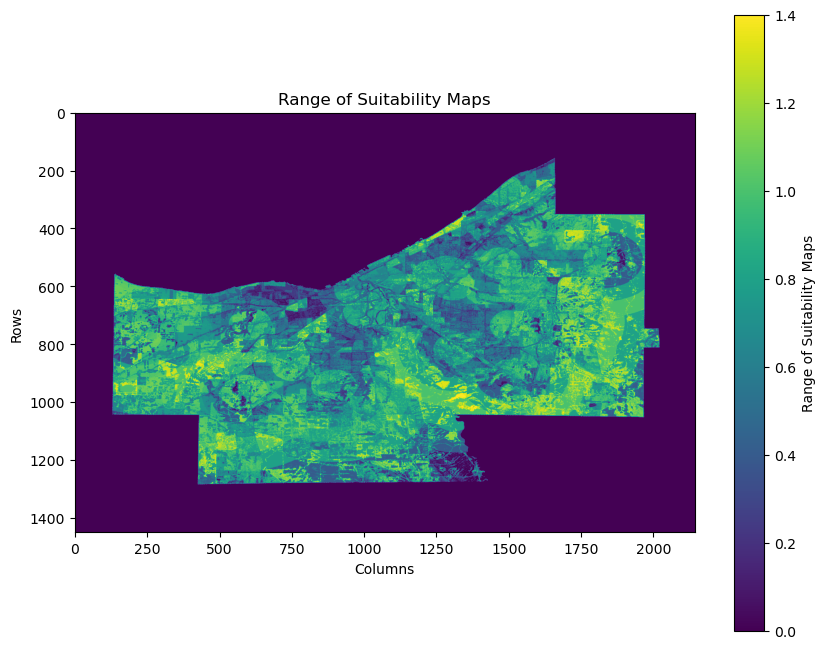

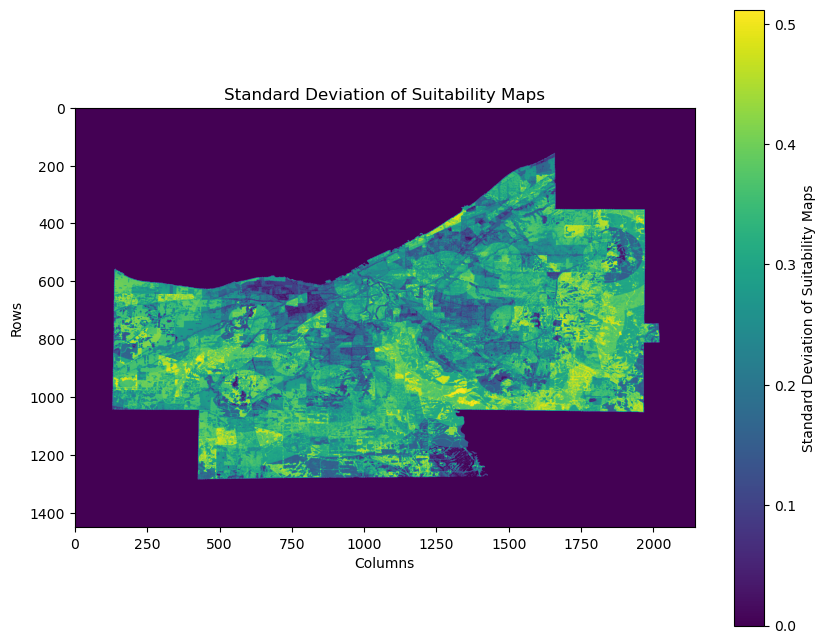

In [18]:
# Plotting function
def plot_map(data, title, cmap='viridis'):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap=cmap)
    plt.colorbar(label=title)
    plt.title(title)
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Plot range and standard deviation
plot_map(range_map, "Range of Suitability Maps")
plot_map(std_dev_map, "Standard Deviation of Suitability Maps")
